# 제4고지 : 신경망 만들기
## 다루게 될 주제
#### 37 단계 : 텐서를 다루다
#### 38 단계 : 형상 변환 함수
#### 39 단계 : 합계 함수
#### 40 단계 : 브로드캐스트 함수
#### 41 단계 : 행렬의 곱
#### 42 단계 : 선형회귀
#### 43 단계 : 신경망

- **tensor, reshape, transpose, sum, broad-casting, matrix multiplication, linear regression, Neural network**
- 이 노트북 셋팅에서는 지금까지 배웠던 내용을 
    - 텐서 상황에서 사용할 수 있도록 **모듈링**하는 것.
    - 이 모든 것을 이용해서 간단한 **선형회귀** 구현
    - 간단한 **신경망 구현**

# Google drive mount

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

pwd 명령어 실행시 gdrive인 상태에서 !git clone 

## STEP 37 : 텐서를 다루다

### 37.1 원소별 계산

In [29]:
import numpy as np
import dezero.functions as F
from dezero import Variable

In [30]:
# scalar or vector
x = Variable(np.array(1.0))
y1 = F.sin(x)

# matrix
x = Variable(np.array([[1,2,3],[4,5,6]]))
y2 = F.sin(x)

print(y1)
print(y2)

variable(0.8414709848078965)
variable([[ 0.84147098  0.90929743  0.14112001]
          [-0.7568025  -0.95892427 -0.2794155 ]])


In [10]:
# element-wise summation

print(y2.shape) # (2,3)

c = np.array([[10,20,30],[40,50,60]])
y2 + c

(2, 3)


variable([[10.84147098 20.90929743 30.14112001]
          [39.2431975  49.04107573 59.7205845 ]])

### 텐서 사용시의 역전파
- 텐서를 이용한 역전파를 구현해봅니다.

In [13]:
x = Variable(np.array([[1,2,3],[4,5,6]]))
c = Variable(np.array([[10,20,30],[40,50,60]]))

t = x + c
y = F.sum(t)

In [14]:
print(y)

variable(231)


In [16]:
y.backward(retain_grad=True)
print(y.grad)
print(t.grad)
print(x.grad)
print(c.grad)

# backward 메서드 호출시 입력했던 t, x, c에 대해서도 역전파가 이루어진 것을 확인할 수 있다.

variable(1)
variable([[2 2 2]
          [2 2 2]])
variable([[3 3 3]
          [3 3 3]])
variable([[3 3 3]
          [3 3 3]])


## 형상 변환 함수
- reshape, transpose

In [20]:
import numpy as np

x = np.array([[1,2,3],[4,5,6]])
y = np.reshape(x, (6,))
print(y)
print("shape of x :",x.shape,"\nshape of y :", y.shape)

[1 2 3 4 5 6]
shape of x : (2, 3) 
shape of y : (6,)


![title](pictures/picture_38-1.png)

역전파는 출력 쪽에서부터 gradient를 전달한다. 이 기울기를 x.data.shape와 x.grad.shape가 동일하도록 변환이 필요하다. 위 그림에서 볼 수 있듯이 vector로 바뀌어 forward 진행을 하고, 다시 backward 할때 2x3의 형태로 바뀌는 것을 볼 수 있다.

Dezero에서 reshape의 함수 구현에 대해서 살펴보자.

In [3]:
import dezero

class Reshape(dezero.Function): 
    # Function을 상속
    def __init__(self, shape):
        self.shape = shape
        
    def forward(self, x):
        self.x_shape = x.shape
        y = x.reshape(self.shape)
        return y
    
    def backward(self, gy):
        return reshape(gy, self.x_shape) 
    
# 1. note : gy는 Variable 인스턴스이므로 np.array나 int, float의 값을 넣어주면 계산이 당연히 되지 않는다.
# 2. note : forward, backward 모두 형상변환(reshape)이 일어나는 것을 볼 수 있다. forward시에는 변환해야 하는 shape(6,)로 변환해주고, 
# backward 시에는 기존 x의 shape로 바꿔준다.

reshape 함수의 구현

In [4]:
from dezero.core import as_variable

def reshape(x, shape):
    if x.shape == Shape:
        return as_variable(x) # Variable 인스턴스로 바꿔줌
    return Reshape(shape)(x) 

# Function에서 __call__ 때문에 가능하다. p46참고

reshape 함수를 사용해보자.

In [7]:
import numpy as np
from dezero import Variable
import dezero.functions as F

x = Variable(np.array([[1,2,3],[4,5,6]]))
y = F.reshape(x, (6,))
y.backward(retain_grad=True)

print("y is :",y)
print("gradient of x :",x.grad)

y is : variable([1 2 3 4 5 6])
gradient of x : variable([[1 1 1]
          [1 1 1]])


어떤 일이 일어나고 있는 것일까?

![title](pictures/picture_38-2.png)

즉, 형상변환함수에 의해 reshape이 일어나고 이에 대해서 각 원소별로 gradient를 계산한 후 다시 형상변환을 적용하고 backward를 진행한 것을 볼 수 있다.

### Variable에서 reshape 사용하기
- dezero의 reshape 함수를 numpy의 reshape와 비슷하게 만들어보자.

먼저 numpy에서 reshape이 어떻게 쓰이는지 보자.

In [8]:
x = np.random.rand(1,2,3)

y = x.reshape((2,3)) # 튜플로 받는다.
y = x.reshape([2,3]) # 리스트도 가능하다.
y = x.reshape(2,3) # 인수를 그대로 받는 것도 가능

dezero에서 이를 구현해봅니다.

In [43]:
import dezero

class Variable_exp(dezero.Variable):
        
    def reshape(self, *shape):
        if len(shape) == 1 and isinstance(shape[0], (tuple, list)):
            shape = shape[0]
        return dezero.functions.reshape(self, shape)
    
# 1. note : isinstance - 인풋된 shape가 튜플 혹은 리스트인지 혹은 어떤 자료형, 클래스인지 확인해준다.

In [44]:
x = Variable_exp(np.random.randn(1,2,3))
y1 = x.reshape((2,3))
y2 = x.reshape(2,3)

print("x looks like : \n", x, "\n")
print(y1,'\n', y2)

x looks like : 
 variable([[[-0.69601877 -0.0803951   0.01445537]
           [-0.15785208 -0.31852705  0.74669398]]]) 

variable([[-0.69601877 -0.0803951   0.01445537]
          [-0.15785208 -0.31852705  0.74669398]]) 
 variable([[-0.69601877 -0.0803951   0.01445537]
          [-0.15785208 -0.31852705  0.74669398]])


### 행렬 전치

![title](pictures/picture_38-3.png)

행렬 전치는 numpy에서 어떻게 이루어지는가?

In [53]:
x = np.array([[1,2,3],[4,5,6]])
y = np.transpose(x)
print(y, '\n shape of x : ' ,x.shape, '\n shape of y : ' , y.shape)     

[[1 4]
 [2 5]
 [3 6]] 
 shape of x :  (2, 3) 
 shape of y :  (3, 2)


dezero에서 transpose 함수 구현

In [55]:
class Transpose(dezero.Function):
    
    def forward(self, x):
        y = np.transpose(x)
        return y
    
    def backward(self, gy):
        gx = transpose(gy)
        return gx

def transpose(x):
    return Transpose()(x)

In [56]:
x = Variable(np.array([[1,2,3],[4,5,6]]))
y = F.transpose(x)
y.backward()
print(x.grad)

variable([[1 1 1]
          [1 1 1]])


Variable 인스턴세에서 transpose 함수를 사용할 수 있도록 다음의 코드를 dezero/core.py에 추가한다.

In [ ]:
class Variable(dezero.Variable):
    
    def transpose(self):
        return dezero.functions.transpose(self)
    
    @property
    def T(self):
        return dezero.functions.transpose(self)
    
# 1. note : property 데코레이터는 '인스턴스 변수'로 사용할 수 있게 해준다.

In [65]:
# property 데코레이터 사용 e.g

x = Variable(np.random.rand(2,3))
y1 = x.transpose()
y2 = x.T

print('y1 is ',y1, '\n y2 is', y2, '\n')
print(y1 - y2)

y1 is  variable([[0.67546866 0.29496431]
          [0.89068117 0.12516986]
          [0.62906504 0.47936913]]) 
 y2 is variable([[0.67546866 0.29496431]
          [0.89068117 0.12516986]
          [0.62906504 0.47936913]]) 

variable([[0. 0.]
          [0. 0.]
          [0. 0.]])


## 합계 함수
Dezero에 합계를 구하는 함수 sum을 추가해보도록 하겠다. 먼저 덧셈의 미분을 복습한 후 sum 함수의 미분을 도출해보도록 한다.

$ y = x_{0} + x_{1}$ 일때, $ dy/dx_{0} = 1, dy/dx_{1} = 1$이라는 것을 볼 수 있다.
![title](pictures/picture_39-1.png)

위 그림은 sum을 진행한 후 역전파를 하는 것을 나타낸다.
기울기 1을 2개로 '복사'해서 다시 back propagation을 진행한다. 

![text](pictures/picture_39-2.png)

위 그림은 벡터로 만든 상태에서 벡터에 sum 연산을 진행한 후 역전파하는 것을 나타낸다.
기울기가 각 벡터 원소별로 계산되어 [1,1]이 나오는 것을 볼 수 있다.

### sum 함수 구현
우리는 위에서 봤던 첫번째 방법으로 sum 함수를 구현한다. 즉, 역전파시 입력 변수의 형상과 같아지도록 기울기의 원소를 **복사**할 것이다.

In [66]:
class Sum(dezero.Function):
    def forward(self, x):
        self.x_shape = x.shape
        y = x.sum()
        return y
    
    def backward(self, gy):
        gx = broadcast_to(gy, self.x_shape)
        return gx

def sum(x):
    return Sum()(x)

# 1. note : 다음 단계에서 구현할 broadcast_to 함수를 미리 사용해서 구현한다.
# broadcast_to 를 이용해서 기존 x_shape과 같은 모양으로 바꿔준다.

In [67]:
import numpy as np
from dezero import Variable
import dezero.functions as F

X = Variable(np.array([1,2,3,4,5,6]))
y = F.sum(x)
y.backward() # 역전파 진행.
print(y)
print(x.grad)

variable(3.094718172802661)
variable([[1. 1. 1.]
          [1. 1. 1.]])


2차원에서도 가능한지 확인해보자

In [68]:
x = Variable(np.array([[1,2,3],[4,5,6]]))
y = F.sum(x)
y.backward()

print(y)
print(x.grad)

variable(21)
variable([[1 1 1]
          [1 1 1]])


기존 input의 모양대로 나오는 것을 볼 수 있다.

### axis & keepdims
단순히 덧셈을 진행하는 것 외에 '축'을 지정해서 해보도록 하자.

In [69]:
x = np.array([[1,2,3],[4,5,6]])
y = np.sum(x, axis=0)
print(y)
print(x.shape, ' -> ', y.shape)

# numpy에서는 이와같이 축을 지정할 수 있다.   
# Q. 만일 axis = 1로 했을 경우 어떤 결과가 나올 까?

[5 7 9]
(2, 3)  ->  (3,)


![title](pictures/picture_39-4.png)

axis에 따른 계산 결과는 다음과 같다.

![title](pictures/picture_39-5.png)

이 외에도 keepdims라는 인수도 존재한다. keepdim는 입력과 출력의 차원 수를 똑같게 유지할지 정하는 플래그이다.

In [72]:
x = np.array([[1,2,3],[4,5,6]])
y = np.sum(x, keepdims = True)

print(x.shape)
print(y)
print(y.shape)

# 입력 dim이 유지가 되는 것을 볼 수 있다.

(2, 3)
[[21]]
(1, 1)


Sum 함수에 axis 기능과 keepdim 기능을 부여해보자.

In [73]:
from dezero import utils

class Sum(dezero.Function):
    
    def __init__(self, axis, keepdims):
        self.axis = axis
        self.keepdims = keepdims
        
    def forward(self, x):
        self.x_shape = x.shape
        y = x.sum(axis = self.axis, keepdims = self.keepdims)
        return y
    
    def backward(self, gy):
        gy = utils.reshape_sum_backward(gy, self.x_shape, self.axis, self.keepdims)
        gx = broadcast_to(gy, self.x_shape)
        return gx
    
def sum(x, axis=None, keepdims =False):
    return Sum(axis, keepdims)(x)

완성된 sum 함수를 Variable의 메서드로 사용할 수 있도록 추가해준다.

In [74]:
class Variable:
    
    def sum(self, axis=None, keepdims=False):
        return dezero.functions.sum(self, axis, keepdims)

In [76]:
# 사용예시
from dezero import Variable

x = Variable(np.array([[1,2,3],[4,5,6]]))
y = F.sum(x, axis=0)
y.backward()
print(y)
print(x.grad)

x = Variable(np.random.rand(2,3,4,5))
y = x.sum(keepdims=True)
print(y.shape)

variable([5 7 9])
variable([[1 1 1]
          [1 1 1]])
(1, 1, 1, 1)


## STEP 40 : 브로드캐스트 함수

이번 장에서는 broadcast_to 함수를 구현한다. DeZero에서도 넘파이와 같은 브로드캐스트를 할 수 있도록 DeZero 함수를 손보겠다.

### 40.1 broadcast_to 함수와 sum_to 함수(넘파이 버전)

In [84]:
# 넘파이에서의 예시

import numpy as np
x = np.array([1,2,3])
y = np.broadcast_to(x, (2,3))
print("y is : \n", y, '\n shape of y : ', y.shape)

y is : 
 [[1 2 3]
 [1 2 3]] 
 shape of y :  (2, 3)


이렇게 브로드캐스트 후 역전파를 수행하면 어떻게 될까?


![title](pictures/picture_40-1.png)

In [96]:
import numpy as np
from dezero.utils import sum_to

x = np.array([[1,2,3],[4,5,6]])
y = sum_to(x, (1,3))
print(y, y.shape)

y = sum_to(x, (2,1))
print(y, y.shape)

[[5 7 9]] (1, 3)
[[ 6]
 [15]] (2, 1)


![title](pictures/picture_40-2.png)

In [ ]:
# Dezero에서 구현된 broadcastto 구현
class BroadcastTo(dezero.Function):
    def __init__(self, shape):
        self.shape=shape
        
    def forward(self, x):
        self.x_shape = x.shape
        y = np.broadcast_to(x, self.shape)
        return y
    
    def backward(self, gy):
        gx = sum_to(gy, self.x_shape)
        return gx

def broadcast_to(x, shape):
    if x.shape == shape : 
        return as_variable(x)
    return BroadcastTo(shape)(x)

In [ ]:
from dezero import utils

class SumTo(dezero.Function):
    def __init__(self, shape):
        self.shape = shape
        
    def forward(self, x):
        self.x_shape = x.shape
        y = utils.sum_to(x, self.shape)
        return y
    
    def backward(self, gy):
        gx = broadcast_to(gy, self.x_shape)
        return gx

def sum_to(x, shape):
    if x.shape == shape:
        return as_varaible(x)
    return SumTo(shape)(x)

### 40.3 브로드캐스트 대응

In [100]:
x0 = np.array([1,2,3])
x1 = np.array([10])
y = x0 + x1
print(y)

[11 12 13]


In [101]:
x0 = Variable(np.array([1,2,3]))
x1 = Variable(np.array([10]))
y = x0 + x1
print(y)

variable([11 12 13])


In [102]:
class Add(dezero.Function):
    def forward(self, x0, x1):
        self.x0_shape, self.x1_shape = x0.shape, x1.shape
        y = x0 + x1
        return y
    
    def backward(self, gy):
        if self.x0_shape != self.x1_shape:
            gx0 = dezero.functions.sum_to(gx0, self.x0_shape)
            gx1 = dezero.functions.sum_to(gx1, self.x1_shape)
        return gx0, gx1

In [103]:
import numpy as np
from dezero import Variable

x0 = Variable(np.array([1,2,3]))
x1 = Variable(np.array([10]))

y = x0 + x1
print(y)

y.backward()
print(x1.grad)

variable([11 12 13])
variable([3])


## STEP 41 : 행렬의 곱

### 41.1 벡터의 내적과 행렬의 곱
- 행렬의 내적 : $ a = (a_1, a_2, ... a_n) $  $ b = (b_1, b_2, ..., b_n) $ 이라고 가정하면 

![벡터의내적](pictures/formula_41.1.png)

- 행렬의 곱 : 

![행렬곱](pictures/picture_41-1.png)

In [113]:
import numpy as np

a = np.array([1,2,3])
b = np.array([4,5,6])
c = np.dot(a,b)
print("the dot product is ", c)

a = np.array([[1,2],[3,4]])
b = np.array([[5,6],[7,8]])
print("the output of matrix multiplication is \n",a@b,'\n\n',np.dot(a,b))
# np.dot은 1차원일 경우 내적을 진행
# 2차원 배열이면 행렬의 곱을 진행한다.

the dot product is  32
the output of matrix multiplication is 
 [[19 22]
 [43 50]] 

 [[19 22]
 [43 50]]


### 41.2 행렬의 형상 체크
행렬과 벡터 계산에서는 '형상'에 주의해야 한다. 

![그림](pictures/picture_41-2.png)

바로, 3x2 행렬과 2x4의 행렬을 곱해서 3x4의 행렬을 만들듯 서로 곱해지는 행렬의 대응하는 차원의 원소 수가 일치해야 한다. 여기서는 앞 행렬의 열이 2, 뒤 행렬의 행이 2로 일치하는 것을 볼 수 있다.

### 41.3 행렬 곱의 역전파
행렬 곱의 역전파를 알아보자. 우리는 행렬 곱의 역전파를 matmul함수로 구현할 것이다.
$ y = xW $라는 계산을 예로 들어 행렬 곱의 역전파를 설명한다. $x$는 1xD, $W$는 DxH, $y$는 1xH의 형태를 지닌다.



![title](pictures/picture_41-3.png)

보다시피 여기서 L은 스칼라에 해당한다. 그렇다면 나온 결과값 L에 대해서 input이었던 $x$에 대해서 미분을 진행하게 된다면 다음과 같이 쓸 수 있다.

![title](pictures/formula_41.2.png)
그러나 사실 $dy_j/dx_i = W_y$가 성립한다. 왜냐하면 $y_j = x_1 W_1j + x_2 W_2j + ... + x_i W_ij + x_H W_Hj$이다. 따라서, $ dy_j / dx_i = W_ij $가 성립함을 알 수 있다.

![title](pictures/formula_41.3.png)
이것은 W의 i행 벡터와 $dL/dy$의 내적이므로 다음과 같이 쓸 수 있다.

![title](pictures/formula_41.4.png)

행렬곱의 역전파를 어떻게 하는지 알아보자. 위의 식을 그대로 반대로하여 역전파를 진행하면 된다. 
$ y = xW $를 예로 생각해보자. x의 형상이 N x D라고 한다면 각각 NxD, DxH, NxH의 형상을 갖게 된다.

![title](pictures/picture_41-5.png) ![title](pictures/picture_41-6.png)

In [124]:
class MatMul(dezero.Function):
    def forward(self, x, W):
        y = x.dot(W)
        return y
    
    def backward(self, gy):
        x, W = self.inputs
        gx = matmul(gy, W.T)
        gW = matmul(x.T, gy)
        return gx, gW
    

def matmul(x, W):
    return MatMul()(x,W)

In [128]:
# 사용 예시
from dezero import Variable
import dezero.functions as F

x = Variable(np.random.randn(2,3))
W = Variable(np.random.randn(3,4))
y = F.matmul(x, W)
y.backward()

print(x,'\n',"shape of x :",x.grad.shape)
print(W,'\n',"shape of W :",W.grad.shape)

variable([[ 0.08418898 -1.04811305 -1.05054897]
          [-1.62394946  1.50056457 -0.2547281 ]]) 
 shape of x : (2, 3)
variable([[ 0.05268812 -0.61597989  0.98095225  0.03847272]
          [-0.2446035  -1.57375072 -0.75989432  3.42012541]
          [-0.23635317 -0.67306886  0.52683415  1.3909708 ]]) 
 shape of W : (3, 4)


## STEP 42 : 선형회귀

### 42.1 토이 데이터셋

In [129]:
import numpy as np

np.random.seed(0) # 시드값 고정
x = np.random.rand(100,1)
y = 5 + 2*x + np.random.rand(100,1) # y에 무작위 노이즈 추가

<AxesSubplot:>

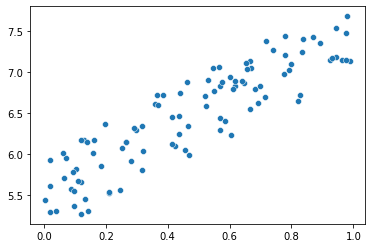

In [139]:
import seaborn as sns

sns.scatterplot(x.reshape(100),y.reshape(100))

### 42.2 선형회귀 이론
> 목표는 주어진 데이터를 잘 표현하는 함수를 찾는 것\
> $ y = Wx + b $의 식으로 **선형** 관계를 표시할 수 있다.

![title](pictures/picture_42-2.png)

이 식에서 오차를 최소화하는 것을 **잔차를 최소화** 하는 것이라 한다. 이를 위해 일종의 오차를 나타내는 지표를 정의하게 된다.

![titel](pictures/formula_42.1.png)
위의 식을 **평균 제곱 오차(mean squared error)** 라고 부른다. 우리는 이것을 **손실함수**라고 부를 것이며, 손실함수의 출력을 최소화하는 방법을 찾아야 한다. 

### 42.3 선형회귀 구현

In [140]:
# 먼저 토이 데이터셋을 구성한다.
import numpy as np
from dezero import Variable
import dezero.functions as F

# toy dataset
np.random.seed(0)
x = np.random.rand(100,1)
y = 5 + 2*x + np.random.rand(100,1)
x, y = Variable(x), Variable(y)

W = Variable(np.zeros((1,1)))
b = Variable(np.zeros(1))

def predict(x):
    y = F.matmul(x,W) + b
    return y

predict 함수는 행렬 곱도 가능한 함수이다. 
![title](pictures/picture_42-3.png)

행렬곱이 이루어지는 원리는 아래와 같다.

![title](pictures/picture_42-4.png)

In [149]:
def mean_squared_error(x0, x1):
    diff = x0 - x1
    return F.sum(diff ** 2) / len(diff)

lr = 0.1
iters = 100

for i in range(iters):
    y_pred = predict(x)
    loss = mean_squared_error(y, y_pred)
    
    W.cleargrad()
    b.cleargrad()
    loss.backward()
    
    W.data -= lr * W.grad.data
    b.data -= lr * b.grad.data
    print('\nthe loss : ',loss)
# loss 가 줄어드는 것을 확인할 수 있다.


the loss :  variable(0.07623408811480073)

the loss :  variable(0.0762340656754432)

the loss :  variable(0.07623404383389304)

the loss :  variable(0.07623402257422397)

the loss :  variable(0.07623400188093413)

the loss :  variable(0.07623398173893459)

the loss :  variable(0.07623396213353843)

the loss :  variable(0.07623394305044999)

the loss :  variable(0.0762339244757544)

the loss :  variable(0.07623390639590762)

the loss :  variable(0.07623388879772634)

the loss :  variable(0.07623387166837853)

the loss :  variable(0.076233854995374)

the loss :  variable(0.07623383876655523)

the loss :  variable(0.07623382297008872)

the loss :  variable(0.07623380759445615)

the loss :  variable(0.07623379262844612)

the loss :  variable(0.07623377806114578)

the loss :  variable(0.07623376388193318)

the loss :  variable(0.07623375008046922)

the loss :  variable(0.0762337366466903)

the loss :  variable(0.07623372357080091)

the loss :  variable(0.07623371084326651)

the loss :  var

이 매개변수로 얻어진 그래프는 아래와 같다.
![title](pictures/picture_42-5.png)

### 42.4 [보충] Dezero의 mean_squared_error 함수
우리는 위에서 mean_squared_error를 구현했다. 그러나 조정이 필요하다. 아래의 그림을 보자.

![title](pictures/picture_42-6.png)

여기서 볼 수 있는 것은 이름 없는 변수 세개가 등장한다는 것이다. 계산 그래프가 존재하는 동안 이것들은 메모리에 계속 남아있게 된다. 좀더 효율적인 방식으로 코드를 구현해보자. 

In [150]:
class MeanSquareError(dezero.Function):
    def forward(self, x0, x1):
        diff = x0 - x1
        y = (diff ** 2).sum() / len(diff)
        return y
    
    def backward(self, gy):
        x0, x1 = self.inputs
        diff = x0 - x1
        gx0 = gy * diff * (2. / len(diff))
        gx1 = -gx0
        return gx0, gx1
    
def mean_squared_error(x0, x1):
    return MeanSquareError()(x0, x1)

# 이렇게 구현하면 중간이 생성되는 변수들 생기지 않는다!

![title](pictures/picture_42-7.png)


## STEP 43 : 신경망

### 43.1 DeZero의 Linear 함수
`y = F.matul(x, W) + b `의 형태를 **선형변환** 혹은 **아핀 변환**이라고 부른다. 
이번 절에서는 앞의 선형 변환을 linear 함수로 구현한다. 우리는 다음과 같이 두 가지 방식으로 구현을 시도한다.

![title](pictures/picture_43-1.png)

In [151]:
# 일단 함수로 구현

def linear_simple(x, W, b=None):
    t = matmul(x, W)
    if b is None:
        return t
    
    y = t + b
    t.data = None
    return y


### 43.2 비선형 데이터셋

In [152]:
import numpy as np

np.random.seed(0)
x = np.random.rand(100,1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1) # 데이터 생성에 sin 함수 이용


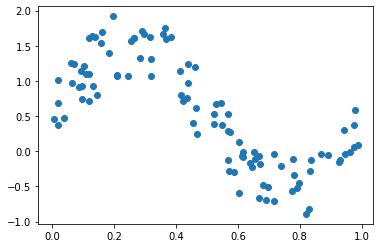

In [160]:
plt.scatter(x,y)

### 43.3 활성화 함수와 신경망
활성화 함수란 신경망에서 선형 변환의 출력에 비선형 변환을 해주는 함수를 말한다. 대표적으로 ReLU, Sigmoid function이 있다. 

![title](pictures/formula_43.1.png)

In [161]:
# dezero에 구현된 sigmoid

def sigmoid_simple(x):
    x = as_variable(x)
    y = 1/(1+exp(-x))
    return y
# exp는 이미 dezero 코드 내에 구현되어 있음.

### 43.4 신경망 구현

In [165]:
# 2층 신경망 구현

def predict(x):
    y = F.linear(x, W1, b1) # 또는 F.linear_simple(...)
    y = F.sigmoid(y) #또는 F.sigmoid_simple(y)
    y = F.linear(y, W2, b2)
    return y
# point : 선형변환후 활성화함수 진행 선형변환 -> 활성화 함수 -> 선형변환 -> 활성화 함수 ...

In [166]:
import numpy as np
from dezero import Variable
import dezero.functions as F

# 데이터셋



![title](pictures/picture_43-4.png)

# discussion questions

1. 텐서란 무엇인가?
2. 텐서를 왜 이용하는가?
3. 텐서로 역전파를 시행하는데, 그 과정을 구체적으로 말해보라.
4. 행렬 전치란 무엇인가?